In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.svm import SVC, LinearSVC
from sklearn.multiclass import OneVsRestClassifier
import sklearn.metrics
import copy

In [17]:
readdata = pd.read_csv("/home/dom/Documents/MPhys/TheGrandTour/Data/wineData.txt", sep="\t");
data = np.array(readdata);
data = np.delete(data, 0, 0)
data = np.swapaxes(data,0,1)

print(data)
for i in range(0, np.shape(data)[0]):
    data[i] = data[i] - np.min(data[i])
    data[i] = (data[i]/np.ndarray.max(data[i]))*2 - 1
# Need to seperate the classification dimension:
classIndex = np.shape(data)[0] - 1
classification = data[classIndex]
data = np.delete(data, classIndex, axis=0)
data = data.astype(float)
d = np.shape(data)[0]
nPoints = np.shape(data)[1]
colour = np.chararray((len(classification)),unicode = True)
colour = np.chararray((len(classification)),unicode = True)
for i in range(len(classification)):
    if classification[i] == 1:
        colour[i] = 'r'
    elif classification[i] == 0:
        colour[i] = 'b'
    elif classification[i] == -1:
        colour[i] = 'g'
labels = np.array([-1,0,1])

[[1.320e+01 1.316e+01 1.437e+01 ... 1.327e+01 1.317e+01 1.413e+01]
 [1.780e+00 2.360e+00 1.950e+00 ... 4.280e+00 2.590e+00 4.100e+00]
 [2.140e+00 2.670e+00 2.500e+00 ... 2.260e+00 2.370e+00 2.740e+00]
 ...
 [3.400e+00 3.170e+00 3.450e+00 ... 1.560e+00 1.620e+00 1.600e+00]
 [1.050e+03 1.185e+03 1.480e+03 ... 8.350e+02 8.400e+02 5.600e+02]
 [1.000e+00 1.000e+00 1.000e+00 ... 3.000e+00 3.000e+00 3.000e+00]]


In [18]:
def iterator(X, G, tau):
    """
    Computes Y(tau) or X^{t+1} given X^t and G
    """
    
    if np.shape(X)[1] > 0.5 * np.shape(X)[0]:
        I = np.identity(np.shape(X)[0])
        W = np.matmul(G, X.T) - np.matmul(X, G.T)
        term = (I + (tau / 2) * W)
        Y = np.matmul(np.linalg.inv(term), np.matmul(term, X))
    else:
        I = np.identity(np.shape(X)[1]*2)
        U = np.concatenate((G, X), axis=1)
        V = np.concatenate((X, -G), axis=1)
        B = np.identity(np.shape(X)[1]*2) + (tau / 2) * np.matmul(V.T, U)
        B = np.linalg.inv(B)
        B = np.matmul(U,B)
        A = np.matmul(V.T,X)
        Y = X - tau*np.matmul(B,A)
    return Y

def derivative(X, costfn, eps = 0.0001):
    G = np.zeros((np.shape(X)[0], np.shape(X)[1]))
    for i in range(np.shape(X)[0]):
        for j in range(np.shape(X)[1]):
            A = copy.deepcopy(X)
            A[i,j] += eps
            G[i,j] = (costfn(A) - costfn(X)) / eps
    return G

def hingeLoss(nData):
    clf = OneVsRestClassifier(SVC(kernel='linear'), n_jobs=-1)
    clf.fit(nData, classification)
    prob = clf.decision_function(nData)
    score = sklearn.metrics.hinge_loss(classification,prob,labels)
    return score

def costfn(X):
    xData = transform(X,data)
    w = hingeLoss(xData)
    return w

def transform(X, data):
    xData = np.dot(data.T,X)
    return xData

def SVM(X):
    nData = transform(X,data)
    clf = OneVsRestClassifier(SVC(kernel='linear'), n_jobs=-1)
    clf.fit(nData, classification)
    score = clf.score(nData, classification)
    return score

def sigma(i):
    s = 0.1
    return s;

def noise(X,var):
    beta = 1 - np.sqrt(2)/2
    I = np.identity(np.shape(X)[0])
    A = beta*np.matmul(X,X.T)
    A = I-A
    B = np.random.normal(0,var,(np.shape(X)))
    return np.matmul(A,B)

In [42]:
def optimise(data, metric, p, tau, T, variance):
    '''
    costfunc - the function to be minimised
    p - number of dimensions to project onto
    tau - step size on Steifel manifold
    T - number of steps
    '''
    minHinge = 10
    maxAcc = 0
    n = np.shape(data)[0] #native dimensions of data
    o = np.shape(data)[1]
    X = np.zeros((n,p)) 
    xData = np.zeros((o,p))
    tX = np.zeros((T,n,p))
    tData = np.zeros((T,o,p))
    tHinge = np.zeros(T)
    jump = []
    for i in range (p):
        X[i,i] = 1
    for i in range(T):
        start = time.time()
        G = derivative(X, costfn)
        Z = G + sigma(i)*noise(X,var=variance)
        Y = iterator(X,Z,tau)
        X = Y
        w = costfn(X)
        tX[i,:,:] = X 
        tData[i,:,:] = transform(X,data)
        tHinge[i] = w
        if  w < minHinge: 
            minHinge = w
            minX = X
            maxAcc = SVM(X)
            jump.append(i)
        end = time.time()
        
        print("Time left: ", (end-start)*(T-i), ", Current values: cost fn: ", costfn(X), ", SVM score: ", SVM(X)," |||||||||||Running Max (Hinge, Accuracy): ", minHinge, maxAcc, " END.", end = "\r")
    tData = np.swapaxes(tData,1,2)
    tX = np.swapaxes(tX,1,2)
    return tData, tX, tHinge, minX, jump, minHinge
    



In [44]:
tau_values = [0.01, 0.04, 0.05, 0.06, 0.1, 0.2, 0.5]
x_saved = []

for i in tau_values:
    print("value for tau: ", i)
    
        for j in range(10):
            tData, tBeta, tHinge, minX, jump, minHinge = optimise(data, hingeLoss, 2, i, 1000, 1)  # p=2, tau, timesteps, variance
        print(jump[-1])
    print("min hinge: " + str(minHinge))
    x_saved.append(minX)
    print("---------new tau----------")
    
    

value for tau:  0.01
last ten jumps: 7240686416626 , Current values: cost fn:  0.02667079997715496 , SVM score:  0.9943502824858758  |||||||||||Running Max (Hinge, Accuracy):  0.026402912570424292 0.9943502824858758  END.D.
0
992
991
990
984
973
971
970
967
966
min hinge: 0.026402912570424292
---------new tau----------
value for tau:  0.05
last ten jumps: 85443592071533 , Current values: cost fn:  0.0017223760204256263 , SVM score:  1.0  |||||||||||Running Max (Hinge, Accuracy):  0.00030621110177959514 1.0  END.9514 1.0  END.58758  END...
0
907
903
819
592
591
583
582
581
580
min hinge: 0.00030621110177959514
---------new tau----------
value for tau:  0.1
last ten jumps: 309938430786133 , Current values: cost fn:  0.0069774438750351275 , SVM score:  1.0  |||||||||||Running Max (Hinge, Accuracy):  0.002301120143246283 1.0  END.5 1.0  END.D.824858758  END.
0
981
980
974
858
853
852
612
606
604
min hinge: 0.002301120143246283
---------new tau----------
value for tau:  0.2
last ten jumps: 

In [46]:
var_values = [0.1, 0.2, 0.5, 0.8, 1, 1.5, 2]
x_var_saved = []

for i in var_values:
    print("value for var: ", i)
    for repeat in range(10):
        tData, tBeta, tHinge, minX, jump, minHinge = optimise(data, hingeLoss, 2, 0.05, 1000, i)  # p=2, tau, timesteps, variance
        print("last ten jumps: ")
        for i in range(10):
            print(jump[-i])
        print("min hinge: " + str(minHinge))
        x_var_saved.append(minX)
    
    print("---------new var----------")

value for var:  0.1
last ten jumps: 64906120300293 , Current values: cost fn:  0.002588553520042391 , SVM score:  1.0  |||||||||||Running Max (Hinge, Accuracy):  0.002588553520042391 1.0  END...58 1.0  END..4858758  END.D.
0
999
973
972
971
961
960
957
911
910
min hinge: 0.002588553520042391
---------new var----------
value for var:  0.2
last ten jumps: 145047187805176 , Current values: cost fn:  0.009593459591899821 , SVM score:  0.9943502824858758  |||||||||||Running Max (Hinge, Accuracy):  0.009482270908493219 0.9943502824858758  END.
0
987
967
932
928
927
920
919
918
914
min hinge: 0.009482270908493219
---------new var----------
value for var:  0.5
last ten jumps: 90738868713379 , Current values: cost fn:  0.004272794987559318 , SVM score:  1.0  |||||||||||Running Max (Hinge, Accuracy):  0.0035513444925622294 1.0  END..703 1.0  END.24858758  END..
0
973
972
968
966
960
937
917
911
910
min hinge: 0.0035513444925622294
---------new var----------
value for var:  0.8
last ten jumps: 78

In [27]:
import sys
import numpy as np
import pyqtgraph as pg
from pyqtgraph.Qt import QtGui, QtCore


if __name__ == '__main__':
    
    plotSVM = 0
    plotNN = 0
    plotDT = 0
    plotBasis = 1
    plotTour = 1
    
    read = 1
    xAxisIndex = 0
    yAxisIndex = 1
    d = np.shape(tData)[1]
    nSteps = np.shape(tData)[0]
    app = 0
    app = QtGui.QApplication([])
    win = pg.GraphicsWindow(title = "GrandTour with SVM")
    win.setGeometry(0,0,1400,1200)
    win.setWindowTitle('GrandTour with SVM')
    pg.setConfigOptions(antialias=True) #dunno what that means

    
    def pause(): 
        global p
        if p == 0:
            p = 1
            pBtn.setText("Play")
            print(j)
        elif p == 1:
            p = 0
            pBtn.setText("Pause")
    
    def forward():
        global j
        j += 1
    def back():
        global j
        j -= 1
    
    j = 0
    p = 0
    jmax = nSteps + 1
    
    proxy = QtGui.QGraphicsProxyWidget()
    pBtn = QtGui.QPushButton("Pause")
    pBtn.clicked.connect(pause)
    proxy.setWidget(pBtn)  
    win.addItem(proxy,row=3,col=1)
    
    fproxy = QtGui.QGraphicsProxyWidget()
    fBtn = QtGui.QPushButton("Forward")
    fBtn.clicked.connect(forward)
    fproxy.setWidget(fBtn)  
    win.addItem(fproxy,row=3,col=2)
    
    bproxy = QtGui.QGraphicsProxyWidget()
    bBtn = QtGui.QPushButton("Back")
    bBtn.clicked.connect(back)
    bproxy.setWidget(bBtn)  
    win.addItem(bproxy,row=3,col=0)
    
    if plotTour == 1:
        w1 = win.addPlot(title="Transformed Points", col = 0, colspan = 2, row = 0, rowspan = 3)
        w1.setGeometry(0,100,14,12)
        nPoints = np.shape(tData)[2]
        s1 = pg.ScatterPlotItem(size=10, pen=pg.mkPen(None), brush=pg.mkBrush(0, 227, 17,120))
        pos = np.zeros((nPoints,2))
        pos[:,0] = tData[0,xAxisIndex,:]
        pos[:,1] = tData[0,yAxisIndex,:]
        if read == 1:
            s1 = pg.ScatterPlotItem(pos=pos, brush = colour, size=0.03, pxMode=False,pen=pg.mkPen(None))
        else: s1 = pg.ScatterPlotItem(pos=pos, size=0.03, pxMode=False,pen=pg.mkPen(None))
        w1.addItem(s1)
        w1.setLabel(text = "Transformed Basis: " + str(xAxisIndex), axis = 'bottom' )
        w1.setLabel(text = "Transformed Basis: " + str(yAxisIndex), axis = 'left' )
        w1.setXRange(-1.5,1.5,padding = None)
        w1.setYRange(-1.5,1.5,padding = None)
    
    if plotSVM == 1 or plotNN == 1 or plotDT == 1:
        jmax = np.argmax(accuracy)
        w2 = win.addPlot(title="Accuracy Plots", col = 0, colspan = 2,row = 2)
        w2.setXRange(0,100,padding = None)
        w2.setYRange(0,1,padding = None)
        SVMcurve = w2.plot(pen='r')
        showSVM = pg.TextItem(text = 'SVM: ' + str(accuracy[0]))
        showSVM.setParentItem(w2)
        NNcurve = w2.plot(pen='b')
        showNN = pg.TextItem(text = 'NN: ' + str(accuracy[0]))
        #showNN.setParentItem(w2)
        DTcurve = w2.plot(pen='g')
        showDT = pg.TextItem(text = 'DT: ' + str(accuracy[0]))
        #showDT.setParentItem(w2)
        jmax = np.argmax(accuracy)
    
    if plotBasis == 1:
        basis = np.arange(0,d)
        w3 = win.addPlot(title= "x Basis", row = 1, col = 2)
        w3.setYRange(0,1,padding = None)
        w4 = win.addPlot(title= "y Basis", row = 2, col = 2)
        w4.setYRange(0,1,padding = None)
    
    
    
    
    def update():
        global j, p
        
        if j > np.shape(tData)[0]-1:
            j =0
            
        if plotTour == 1:    
            pos[:,0] = tData[j,xAxisIndex,:]
            pos[:,1] = tData[j,yAxisIndex,:]
            if read == 1:
                s1.setData(pos = pos,brush = colour)
            else: s1.setData(pos = pos)
        if plotSVM == 1:
            SVMcurve.setData(SVMaccuracy[0:j])
            showSVM.setText('SVM: ' + str(round(SVMaccuracy[j],3)))
        if plotNN == 1:
            NNcurve.setData(NNaccuracy[0:j])
            showSVM.setText('NN: ' + str(round(NNaccuracy[j],3)))
        if plotDT == 1:
            DTcurve.setData(DTaccuracy[0:j])
            showSVM.setText('DT: ' + str(round(DTaccuracy[j],3)))
        
            
        if plotBasis == 1:
            w3.clear()
            w4.clear()
            basis1 = pg.BarGraphItem(x = basis, height = abs(tBeta[j,xAxisIndex,0]), width=0.1, brush='g')
            w3.addItem(basis1)
            basis2 = pg.BarGraphItem(x = basis, height = abs(tBeta[j,yAxisIndex,0]), width=0.1, brush='g')
            w4.addItem(basis2)
    
       
        
            
        if not p:
            if plotSVM == 1 or plotNN == 1 or plotDT == 1:
                w2.setXRange(0,np.shape(tData)[0],padding = None)
            j += 1
            if j == jmax:
                pause()
    t = QtCore.QTimer()
    t.timeout.connect(update)
    t.start(60)

## 2) Spots are transform-invariant, but not identical (top-right plot). 
## In this case, drawing is almsot as fast as 1), but there is more startup 
## overhead and memory usage since each spot generates its own pre-rendered 
## image.
    sys.exit(app.exec_())
    



87
7


SystemExit: 0

In [70]:
import 

(3000, 2, 13)

In [72]:
mag = np.linalg.norm(tBeta,axis=1)

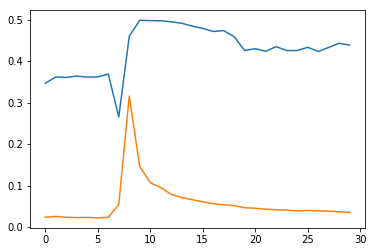

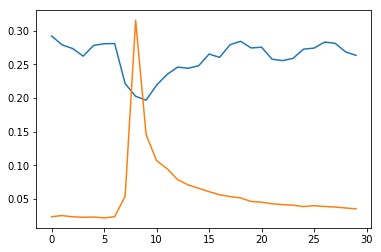

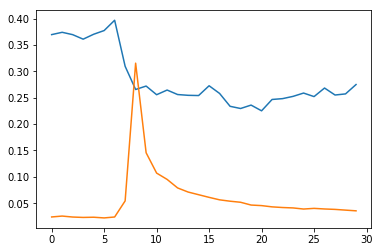

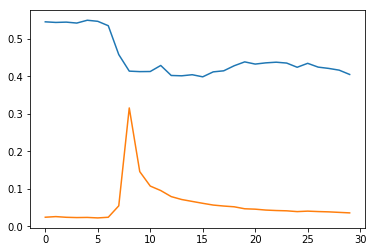

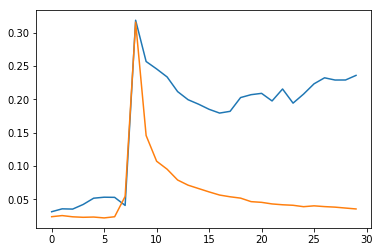

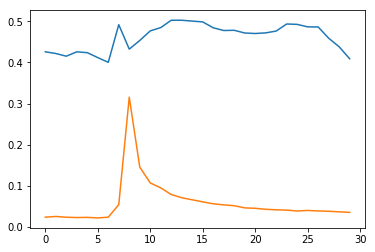

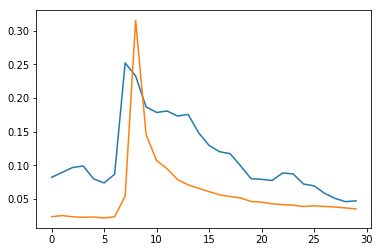

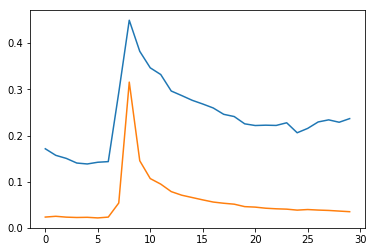

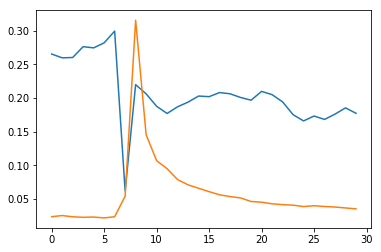

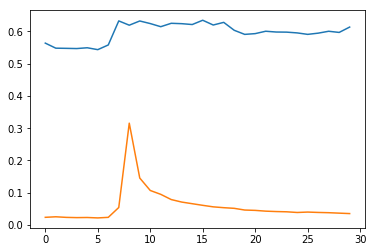

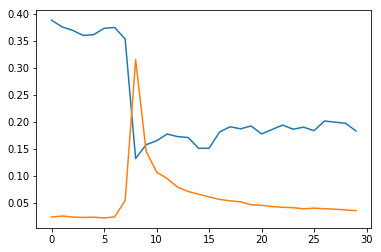

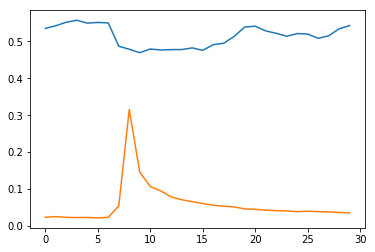

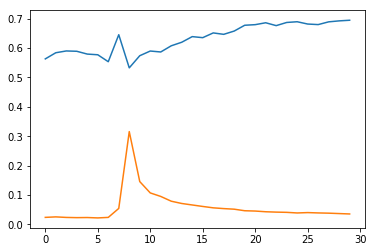

In [90]:
for i in range(np.shape(mag)[1]):
    plt.plot(mag[1020:1050,i])
    plt.plot(tHinge[1020:1050])
    plt.show()

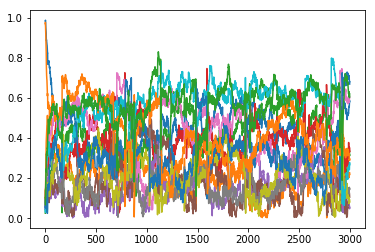

In [81]:
plt.plot(mag[:])
plt.show()

In [84]:
print(mag[352]-mag[1443])
print(mag[352])
print(mag[1443])

[-0.16750331  0.11385142 -0.10938572 -0.03191089 -0.12025415  0.12878951
  0.14370605  0.00941168 -0.05803514 -0.10192327  0.02874685  0.28062057
 -0.07955909]
[0.29149101 0.20253044 0.43273142 0.32841868 0.10951497 0.21029993
 0.54833141 0.2073623  0.19118764 0.54013773 0.23864649 0.69565377
 0.55661948]
[0.45899432 0.08867902 0.54211715 0.36032957 0.22976913 0.08151042
 0.40462537 0.19795062 0.24922278 0.642061   0.20989964 0.41503321
 0.63617857]


In [86]:
proj = transform(tBeta[353], data)

ValueError: shapes (177,13) and (2,13) not aligned: 13 (dim 1) != 2 (dim 0)